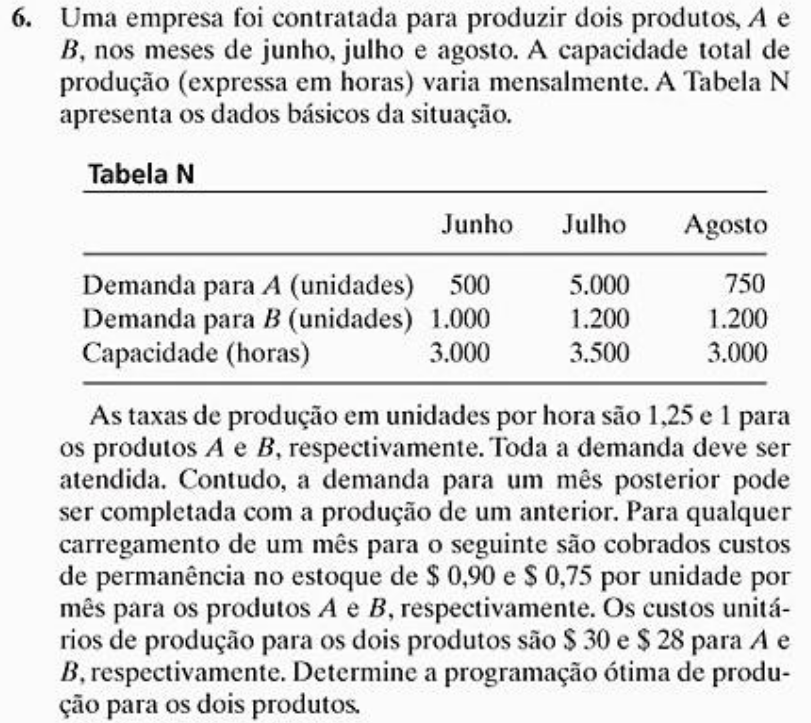

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Planejamento_Producao_Multiperiodo')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Períodos de tempo e produtos
meses = ['junho', 'julho', 'agosto']
produtos = ['A', 'B']

# Demanda mensal (unidades)
demanda = {
    'A': {'junho': 500, 'julho': 5000, 'agosto': 750},
    'B': {'junho': 1000, 'julho': 1200, 'agosto': 1200}
}

# Capacidade de produção mensal (horas)
capacidade_horas = {'junho': 3000, 'julho': 3500, 'agosto': 3000}

# Dados de produção e custo
# Taxa de produção A = 1.25 unid/h  =>  Tempo por unidade A = 1/1.25 = 0.8 h/unid
# Taxa de produção B = 1 unid/h    =>  Tempo por unidade B = 1/1 = 1.0 h/unid
horas_por_unidade = {'A': 0.8, 'B': 1.0}
custo_producao_unitario = {'A': 30, 'B': 28}
custo_estoque_unitario_mes = {'A': 0.90, 'B': 0.75}

In [4]:
# 1. Variáveis de Decisão
# Quantidade a produzir de cada produto em cada mês
producao = model.continuous_var_matrix(produtos, meses, name='Prod')

# Quantidade em estoque de cada produto no final de cada mês
estoque = model.continuous_var_matrix(produtos, meses, name='Estoque', lb=0)


# 2. Função Objetivo
# Minimizar o custo total (Produção + Estoque)
expressao_custo_prod = (custo_producao_unitario[p] * producao[p,m]
                        for p in produtos for m in meses)
soma_custo_prod = model.sum(expressao_custo_prod)

expressao_custo_est = (custo_estoque_unitario_mes[p] * estoque[p,m]
                       for p in produtos for m in meses)
soma_custo_est = model.sum(expressao_custo_est)

custo_total = soma_custo_prod + soma_custo_est
model.minimize(custo_total)


# 3. Restrições

# Restrição 1: Balanço de Estoque (para cada produto, em cada mês)
# Estoque_Inicial + Produção - Demanda = Estoque_Final
for p in produtos:
    for idx, m in enumerate(meses):
        estoque_inicial = estoque[p, meses[idx-1]] if idx > 0 else 0
        restr_balanco_logica = estoque_inicial + producao[p,m] - demanda[p][m] == estoque[p,m]
        model.add_constraint(restr_balanco_logica, ctname=f'balanco_{p}_{m}')

# Restrição 2: Capacidade de Produção (para cada mês)
for m in meses:
    expressao_horas_usadas = (horas_por_unidade[p] * producao[p,m] for p in produtos)
    soma_horas_usadas = model.sum(expressao_horas_usadas)
    restr_capacidade_logica = soma_horas_usadas <= capacidade_horas[m]
    model.add_constraint(restr_capacidade_logica, ctname=f'capacidade_{m}')

In [5]:
# Célula 5 Melhorada

# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
# Verifica se uma solução foi encontrada
if solucao:
    custo_minimo = model.objective_value
    print(f"Custo Total Mínimo: ${custo_minimo:,.2f}\n")

    print("--- Plano de Produção (unidades por mês) ---")
    for m in meses:
        print(f"Mês de {m.capitalize()}:")
        for p in produtos:
            prod_val = producao[p,m].solution_value
            if prod_val > 1e-6:
                print(f"  - Produto {p}: {prod_val:,.2f} unidades")

    print("\n--- Nível de Estoque (unidades no final do mês) ---")
    for m in meses:
        print(f"Final de {m.capitalize()}:")
        for p in produtos:
            est_val = estoque[p,m].solution_value
            print(f"  - Produto {p}: {est_val:,.2f} unidades")
else:
    # Informa o status do erro
    print(f"Não foi possível encontrar uma solução ótima. Status do Solver: {model.solve_details.status}")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Tried aggregator 1 time.
Aggregator did 2 substitutions.
Reduced LP has 7 rows, 10 columns, and 18 nonzeros.
Presolve time = 0.00 sec. (0.01 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =        193000.000000

------ SOLUÇÃO ÓTIMA ------

Não foi possível encontrar uma solução ótima. Status do Solver: infeasible
